# Incremental Insertion und Randomized Incremental Insertion
## Tim Krampitz, Felix Roscher
11.01.2019

## Grundlagen

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Drei Punkte sind konvex, wenn ihre Determinate postiv ist
$$ \Delta(a,b,c) = \begin{vmatrix} x_a & y_a & 1 \\ x_b & y_b & 1 \\ x_c & y_c & 1 \end{vmatrix} > 0$$

In [2]:
def isLeftTurn(a,b,c):
    return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0]) > 0

In [3]:
def getAngle(anchor, point):
    diff = point - anchor
    return np.arctan2(diff[1], diff[0])

In [4]:
def findAchorPointIndex(pts):
    return np.argsort(pts[:,1])[0]

In [5]:
def sortCCW(anchorIndex, pts):
    lst = np.delete(pts, anchorIndex, axis=0)
    
    angles = [ getAngle(pts[anchorIndex], point) for point in lst ]
    return lst[np.argsort(angles)]

## Incremental Insertion (Sweeping)

In [6]:
def sortXIndex(pts):    
    return np.argsort(pts[:,0])

In [7]:
def grahamScan(pts):
    anchorIndex = findAchorPointIndex(pts)
    anchor = pts[anchorIndex]
    ptsCCW = sortCCW(anchorIndex, pts)
    hull = np.empty((0,2))    
    
    for p in ptsCCW:
        hull = np.vstack((hull, p))
        while len(hull) >= 3:
            i = len(hull) - 1
            if not isLeftTurn(hull[i-2],hull[i-1],hull[i]):
                hull = np.delete(hull, i-1, axis=0)
            else:
                break
    hull = np.vstack((hull, anchor))
    hull = np.insert(hull, 0 ,anchor, axis=0)
    return hull

Klassendefinition eines Knotenpunktes mit Koordinaten, Nachfolger und Voränger

toList(self): Schreibt Koordinaten als Punkt (x,y)

In [8]:
class SweepPoint:
    def __init__(self, x = 0, y = 0):
        self.x = x
        self.y = y

    def __repr__(self):
        return "X:" + str(self.x) + " Y:" + str(self.y) + " Next:" + str(self.next) + " Prev:" + str(self.prev)
    
    def toList(self):
        return [self.x, self.y]

## sweepHull
1. Initialisierung
   - Punktobjekte
   - 1. und 2. Punkt als triviale konvexe Hülle
2. Hinzufügen des nächst linken Punktes (nächster in der Liste)
   - Prüfen ob Y-Koordinate kleiner/größer als vorheriger Punkt für einfügen gegen den Uhrzeigersinn
   - Setzen des Vorgänger und Nachfolgers des neuen Punkts
   - Hinzufügen des neuen Punkts als Nachfolger/Vorgänger der angrenzenden Punkte (dazwischen schieben)
3. Prüfen ob Vorgänger eine "Linksdrehung" darstellen
   - Ja $\rightarrow$ Mittelpunkt entfernen
   - Nein $\rightarrow$ Nichts tun
4. Analoge Prüfung Nachfolger auf "Linksdrehung"


In [9]:
def sweepHull(pts):
    lst = [ SweepPoint(pts[i][0],pts[i][1]) for i in sortXIndex(pts) ] # nach X aufs. sortierte Liste mit SweepPoint Objeketen
    lst[0].next = 1
    lst[0].prev = 1
    
    lst[1].next = 0
    lst[1].prev = 0 # Startbedingung, Zweipunktkonvexhülle
    
    for i in range(2, len(lst)):
        if lst[i].y < lst[i-1].y:
            lst[i].next = i-1
            lst[i].prev = lst[i-1].prev
        else:
            lst[i].prev = i-1
            lst[i].next = lst[i-1].next
        
        lst[lst[i].prev].next = i
        lst[lst[i].next].prev = i
        
        while isLeftTurn(lst[i].toList(), lst[lst[i].prev].toList(), lst[lst[lst[i].prev].prev].toList()):
            lst[lst[lst[i].prev].prev].next = i
            lst[i].prev = lst[lst[i].prev].prev
            
        while isLeftTurn(lst[lst[lst[i].next].next].toList(), lst[lst[i].next].toList(), lst[i].toList()):
            lst[lst[lst[i].next].next].prev = i
            lst[i].next = lst[lst[i].next].next

    out = [lst[0]]
    while out[len(out) - 1].next != 0:
        out.append(lst[out[len(out) - 1].next])
    out.append(lst[out[len(out) - 1].next])
    return [i.toList() for i in out]            

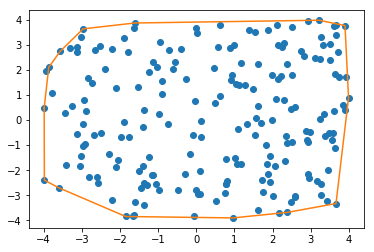

In [19]:
pts =  np.random.uniform(low=-4,high=4, size=(200,2))
hull = np.array(sweepHull(pts))

plt.plot(pts[:,0], pts[:,1], 'o')
plt.plot(hull[:,0], hull[:,1])
plt.show()


## Randomized Incremental Insertion

### Algorithmus

* Aufbauend auf Incremental Insertion, hinzufügen der Punkte zufällig
* Punkte haben Pointer zu **irgend einer** sichtbarer Kante
* Hinzufügen des nächsten Punkts:
    - Innerhalb der Hülle: darstellen und Null-Pointer
    - Außerhalb der Hülle: wie bei Incremental Insertion mit analoger "Hüllenreperatur"

In [ ]:
pts[] = Punktemenge
    lst[0].next = 1
    lst[0].prev = 2
    
    lst[1].next = 2
    lst[1].prev = 0 
    
    lst[2].next = 0
    lst[2].prev = 1
    sort lst CCW  #initiale 3-Punkt-Hülle
    set Pointers and conflictList  #Pointer der Punkte und Liste pro Kante mit daraufzeigenden Punkten

for i in range(3, len(pts))
    if i notin Hull:
        remove conflictEdge #Kante auf welche der Punkt zeigt
        connect Point with endpoints of conflictEdge
        repair Hull and mark Points with removed conflictEdge
        set Pointer of marked Points
            if inside formed triangle: #i with neightbors of polygon
                pointer = None
            else:
                pointer on visible new edge #one of two     
        


## Korrektheit und Laufzeit
* Korrektheit: Fallunterscheidung zum Hinzufügen von Punkten:
    1. Innerhalb bestehender Hülle
    2. Außerhalb bestehender Hülle

* Laufzeit:
    * 

## Quellen

http://www.faculty.jacobs-university.de/llinsen/teaching/320201/Lecture25.pdf